In [1]:
import pandas as pd
import numpy as np
import csv
import math
from sklearn.linear_model import PassiveAggressiveRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime, timedelta
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
# import xgboost as xgb

import constants

# Data Functions

In [12]:
def load_static_data():
    static_sensor_data=[]
    for sensor in constants.SENSOR_IDS:
        list_ = []
        for date in constants.SELECT_DATES:
            filename = "/Users/ryanegan/Documents/diss/RawData/static/{}/{}.csv".format(date, sensor)
            df = pd.read_csv(filename,index_col=None)
            df['lat'] = constants.STATIC_COORDS[sensor][0]
            df['long'] = constants.STATIC_COORDS[sensor][1]
            # Calibration
            df['PM1'] = df['PM1'].values / constants.CALIBRATION_FACTORS[sensor][0]
            df['PM2.5'] = df['PM2.5'].values / constants.CALIBRATION_FACTORS[sensor][1]
            df['PM10'] = df['PM10'].values / constants.CALIBRATION_FACTORS[sensor][2]
            df['temperature'] = df['temperature'].values / constants.CALIBRATION_FACTORS[sensor][3]
            df['humidity'] = df['humidity'].values / constants.CALIBRATION_FACTORS[sensor][4]
            # -----------
            list_.append(df)
        static_sensor_data.append(pd.concat(list_, axis = 0, ignore_index = False))
    all_static_data = pd.concat(static_sensor_data, axis = 0, ignore_index = False)
    # Select columns
    all_static_data = all_static_data[constants.COLUMNS]
    all_static_data = all_static_data.dropna()
    return all_static_data

def load_mobile_sensors():
    list_ = []
    for sensor in constants.MOBILE_SENSORS:
        for date in constants.SELECT_DATES:
            filename = "/Users/ryanegan/Documents/diss/RawData/personal/{}/{}_{}.csv".format(date, sensor, date)
            df = pd.read_csv(filename,index_col=None)
            list_.append(df)
        mobile_sensor_data = (pd.concat(list_, axis = 0, ignore_index = False))
        mobile_sensor_data['lat'] = mobile_sensor_data['latitude']
        mobile_sensor_data['long'] = mobile_sensor_data['longitude']
        # Calibration
        df['PM1'] = df['PM1'].values / constants.CALIBRATION_FACTORS[sensor][0]
        df['PM2.5'] = df['PM2.5'].values / constants.CALIBRATION_FACTORS[sensor][1]
        df['PM10'] = df['PM10'].values / constants.CALIBRATION_FACTORS[sensor][2]
        df['temperature'] = df['temperature'].values / constants.CALIBRATION_FACTORS[sensor][3]
        df['humidity'] = df['humidity'].values / constants.CALIBRATION_FACTORS[sensor][4]
        #Select columns
        mobile_sensor_data = mobile_sensor_data[constants.COLUMNS]
    return mobile_sensor_data

#Transform to grid coordinates
def grid_lat_coord(lat):
    if lat < 55.93814 or lat > 55.94686:
        return -1
    i = 0
    for lat_check in np.linspace(55.93814,55.94686,constants.GRID_SIZE+1)[1:]:
        if lat < lat_check:
            return 19-i
        i+=1

def grid_long_coord(long):
    if long < -3.19665 or long > -3.18123:
        return -1
    i = 0
    for long_check in np.linspace(-3.19665,-3.18123,constants.GRID_SIZE+1)[1:]:
        if long < long_check:
            return i
        i+=1

def transform_to_grid_coordinates(data):
    data['lat_grid'] = data['lat'].apply(grid_lat_coord)
    data['long_grid'] = data['long'].apply(grid_long_coord)
    data = data[data['lat_grid'] >= 0]
    data = data[data['long_grid'] >= 0]
    return data

def add_land_type(data):
    data['land_type'] = np.vectorize(get_land_type)(data['lat_grid'], data['long_grid'])
    
    one_hot = pd.get_dummies(data['land_type'])
    data = data.join(one_hot)
    data.rename(columns={1.0: 'commercial', 2.0: 'residential', 3.0: 'green'}, inplace=True)
    data.drop(['land_type'],axis=1, inplace=True)
    
    return data

def get_land_type(x, y):
    return landuse[int(x)][int(y)]

def add_road_type(data):
    osm_dir = "/Users/ryanegan/Documents/diss/projectZoe/data/osm/"
    road_file = osm_dir + "roadtype_grid" + str(constants.GRID_SIZE) + ".csv"

    pd_df2=pd.read_csv(road_file, sep=',',header=None, skiprows=1)
    roadtype = pd_df2.values
    
    data['road_type'] = np.vectorize(get_road_type)(data['lat_grid'], data['long_grid'])
    
    one_hot = pd.get_dummies(data['road_type'])
    data = data.join(one_hot)
    data.rename(columns={0.0: 'primary', 1.0: 'secondary', 2.0: 'tertiary', 3.0: 'unclassified', 4.0: 'residential/service', 5.0: 'pedestrian/cycle/noroad'}, inplace=True)
    data.drop(['road_type'],axis=1, inplace=True)
    
    return data

def get_road_type(x, y):
    return roadtype[int(x)][int(y)]

def add_labels(data):
    data['prev_pm_2.5'] = np.vectorize(get_previous_pm)(data['lat_grid'], data['long_grid'], data['timestep'])
    return data

def get_previous_pm(lat, long, timestep):
    for i in range(constants.GRID_SIZE):
        prev_data = all_data[(np.abs(all_data['lat_grid'] - lat) <= i) & (np.abs(all_data['long_grid'] - long) <= i) & (all_data['timestep'] == timestep - 1)]
        if(not prev_data.empty):
            prev_pm = prev_data['PM2.5'].mean()
            return prev_pm
    
def setIds(data):
    startTime = constants.START_TIME
    endTime = (datetime.strptime(startTime, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=5)).strftime("%Y-%m-%d %H:%M:%S")
    i = 0
    j=0
    data['timestep'] = ''
    data['timestepContinuous'] = ''
    
    while startTime < constants.END_TIME:
        
        data['timestep'] = np.where((data['Timestamp'] >= startTime) & (data['Timestamp'] < endTime), int(i), data['timestep'])
        i+=1
        
        if (data[(data['Timestamp'] >= startTime) & (data['Timestamp'] < endTime)].shape[0] != 0):
            data['timestepContinuous'] = np.where((data['Timestamp'] >= startTime) & (data['Timestamp'] < endTime), int(j), data['timestepContinuous'])
            j+=1
        startTime = endTime
        endTime = (datetime.strptime(endTime, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=constants.WINDOW)).strftime("%Y-%m-%d %H:%M:%S")
        

# LOAD DATA

In [31]:
# staticData = load_static_data()
# staticData = transform_to_grid_coordinates(staticData)
# mobileData = load_mobile_sensors()
# mobileData = transform_to_grid_coordinates(mobileData)
# allData = pd.concat([staticData, mobileData], ignore_index=True)
# setIds(staticData)
# setIds(allData)
# allData

with open("all_data_15_min.txt", "rb") as fp:   # Unpickling
    all_data = pickle.load(fp)



all_data = all_data.dropna()


# Model Functions

In [32]:
#TODO add params for activations, num layers, width of layers, optimizer, loss function, learning rate, batch size
def createStationaryModel():
    online_model = tf.keras.Sequential([
        layers.Dense(12, activation=tf.nn.relu, input_shape=[len(constants.CONTINUOUS_TRAINING_FEATURES)]),
#         layers.Dense(16, activation=tf.nn.relu),
#         layers.Dense(16, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    online_optimizer = tf.keras.optimizers.Adam(0.00001)

    online_model.compile(loss='mean_absolute_error',
        optimizer=online_optimizer,
        metrics=['mean_absolute_error', 'mean_squared_error'])
    
    par = PassiveAggressiveRegressor(C=1, epsilon=0.1, loss='epsilon_insensitive', max_iter=100, random_state=0,tol=1e-3)
    
    return online_model, par


In [33]:
online_model, par_model = createStationaryModel()


# Train

In [34]:
def updateModels(data, label):
    
    X = data[constants.CONTINUOUS_TRAINING_FEATURES]
    #uncomment for predict one datapoint
#     label = np.array([label])
    online_model.fit(
        X, label, batch_size=1,
        epochs=25, verbose=0)
    
    online_model2.fit(
        X, label, batch_size=1,
        epochs=70, verbose=0)

    par_model.partial_fit(X, label)
                
def trainNNs(trainData):
    
    class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            if epoch % 100 == 0: print('')
            print('.', end='')
                
    
        
    X = trainData[constants.CONTINUOUS_TRAINING_FEATURES]
    labels = trainData.pop('PM2.5')
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

    par_model.fit(X, labels)

    history = online_model.fit(
        X, labels, batch_size=8,
        epochs=2000, verbose=0, validation_split = .2, callbacks=[ early_stop, PrintDot()])

    plot_history(history)
    hist = pd.DataFrame(history.history)
    display(hist)
    
        
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.legend()

In [35]:
# all_data = all_data.assign(nextPM=all_data['PM2.5'].shift(-3))
# all_data['minute'] = all_data.apply(lambda row: datetime.strptime(row.Timestamp[:19], '%Y-%m-%d %H:%M:%S').minute, axis=1)
# staticData['hour'] = staticData.apply(lambda row: datetime.strptime(row.Timestamp[:19], '%Y-%m-%d %H:%M:%S').hour, axis=1)

# allData['grid'] = allData.apply(lambda row: str([row.lat_grid, row.long_grid]), axis=1)

# train = all_data[(all_data['timestepContinuous'] <= 400) |  (all_data['timestepContinuous'] > 800)]
# valid = all_data[(all_data['timestepContinuous'] <= 800) & (all_data['timestepContinuous'] > 400)]

train = all_data[all_data['timestepContinuous'] <= 1450]
valid = all_data[(all_data['timestepContinuous'] > 1450)]

# Train Functions


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................................

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
0,3.293952,3.293955,14.169175,2.263835,2.263834,10.159164
1,1.503281,1.503281,5.570788,1.572918,1.572918,10.173040
2,1.200964,1.200963,5.151373,1.574928,1.574927,10.550374
3,1.175955,1.175955,5.132181,1.555422,1.555421,10.458450
4,1.155193,1.155194,5.069764,1.542984,1.542985,10.428007
5,1.137234,1.137233,5.030039,1.529870,1.529869,10.349711
6,1.121839,1.121839,4.981359,1.523483,1.523483,10.381913
7,1.108287,1.108286,4.956869,1.512870,1.512870,10.313023
8,1.096308,1.096308,4.918036,1.511570,1.511570,10.426148
9,1.084714,1.084714,4.905715,1.501708,1.501708,10.369859


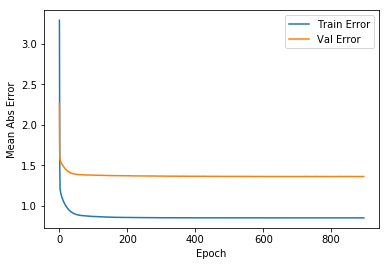

In [36]:
trainNNs(train)

# Test Time Functions

In [37]:
def copy_model(model):
    batch_model = keras.models.clone_model(model)
    batch_model.build((None, len(constants.CONTINUOUS_TRAINING_FEATURES)))
    batch_model.compile(optimizer='adam', loss='mean_absolute_error')
    batch_model.set_weights(model.get_weights())
    
    return batch_model

def predictOneDataPoint(X):
    label = X.pop('PM2.5')
    X = np.array(X[constants.CONTINUOUS_TRAINING_FEATURES])
    online_pred = online_model.predict(X)
    batch_pred = batch_model.predict(X)
    online_model2_pred = online_model2.predict(X)
    par_pred = par_model.predict(X)
    
    return (online_pred[0], online_model2_pred[0], batch_pred[0], par_pred[0], label.iloc[0])

def predictOneTimestep(X):
    label = X.pop('PM2.5')
    X = np.array(X[constants.CONTINUOUS_TRAINING_FEATURES])
    online_pred = online_model.predict(X)
    batch_pred = batch_model.predict(X)
    online_model2_pred = online_model2.predict(X)
    par_pred = par_model.predict(X)
        
    return (online_pred, online_model2_pred, batch_pred, par_pred, np.array(label.values).ravel())
    

def getFullPredictions(data):
    online_predictions = []
    online_predictions2 = []
    batch_predictions = []
    ensemble = []
    par_predictions = []
    baseline_predictions = []
    all_labels = []
       
    start = int(data['timestepContinuous'].min())
    end = int(data['timestepContinuous'].max())
    for i in range(start, end):
        print(i)
#     for i in range(1522, 1523):
#         print(i)
        newData = data[data['timestepContinuous'] == i]
        
#         online_pred, online_pred2, batch_pred, par_pred, label = predictOneDataPoint(newData)
        if(newData.empty != True):
            online_pred, online_pred2, batch_pred, par_pred, label = predictOneTimestep(newData)
            for j in range(len(newData)):
                
                online_predictions.append(online_pred[j])
                par_predictions.append(par_pred[j])
                online_predictions2.append(online_pred2[j])
                batch_predictions.append(batch_pred[j])

                ensemble_pred = (.5 * online_pred[j]) + (.5 * online_pred2[j])

                ensemble.append(ensemble_pred)
                all_labels.append(label[j])
                
            updateModels(newData, label)
    return (online_predictions, online_predictions2, batch_predictions, ensemble, all_labels, par_predictions)

In [38]:
batch_model = copy_model(online_model)
online_model2 = copy_model(online_model)
online_preds, online_preds2, batch_predictions, ensemble_preds, labels, par_preds = getFullPredictions(valid)
print(mean_absolute_error(online_preds, labels))
print(mean_absolute_error(online_preds2, labels))
print(mean_absolute_error(batch_predictions, labels))
print(mean_absolute_error(ensemble_preds, labels))
print(mean_absolute_error(par_preds, labels))


1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650


In [39]:
np.mean(np.abs(np.diff(labels)))


0.44529899319782595

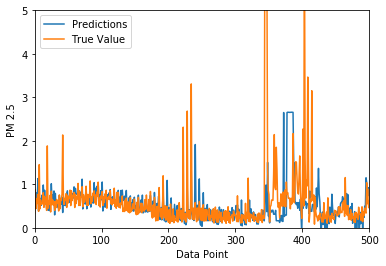

In [43]:
def plot_preds(preds, labels):
#     hist = pd.DataFrame(history.history)
#     hist['epoch'] = history.epoch

    x = range(len(preds))
    plt.figure()
    plt.xlabel('Data Point')
    plt.ylabel('PM 2.5')
    plt.plot(x, preds,
           label='Predictions')
    plt.plot(x, labels,
           label = 'True Value')
    plt.ylim([0,5])
    plt.xlim([0, 500])
    plt.legend()

    plt.show()

plot_preds(online_preds2, labels)
